## An Insight in Ecuador's Education System

### Main Goal:
The main goal of this project is to uncover and provide an insight into education trends in Ecuador, bringing light to existing issues through data analysis and visualizations techniques.

### The Project:

I will be analyzing student-teacher trends across provinces and time, national literacy indicators and educational expenditure:
1. Find data sources
2. Clean data
3. Explore trends
4. Prepare data for plotting
5. Plot


### Student-Teacher Ratio: Obtaining and Cleaning the Data 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from functools import reduce
%matplotlib inline

In [2]:
def get_data(file):
    df = pd.read_excel(file)
    data_raw = pd.DataFrame(df, columns=['Provincia','Escolarización','Sostenimiento', 
                             'Modallidad','Total Docentes','Total Estudiantes']).query("(Escolarización == 'Escolarizada') & (Provincia != 'Zona No Delimitada')")
    
    data_raw = data_raw[(data_raw['Total Docentes']>0) & (data_raw['Total Estudiantes']>0)]
    data_raw.dropna(subset=['Total Docentes', 'Total Estudiantes', 'Provincia'], inplace = True)
    
    ## These pronvinces were unified and are shown as one in geomap
    data_raw.replace({'SANTO DOMINGO DE LOS TSACHILAS': 'PICHINCHA', 'SANTA ELENA': 'GUAYAS'}, inplace=True)
    
    data_raw.reset_index(drop = True, inplace=True)
    
    ## Set all types of private school as a single private type
    def f(x):
        if 'Particular' in x:
            return 'Particular'
        else:
            return x
        
    data_raw['Sostenimiento'] = data_raw['Sostenimiento'].apply(f)
    
    return data_raw

In [3]:
## Create student-teacher ratio

def total_public_ratio(data_raw):
    data = data_raw.query("(Sostenimiento == 'Fiscal') & (Modallidad == 'Presencial')")#" & (Escolarización == 'Escolarizada') ")
   
    data.reset_index(inplace=True)
    data.drop('index', axis=1)
    
    data['Ratio'] = data['Total Estudiantes']/data['Total Docentes']
    return data

def total_private_ratio(data_raw):
    data = data_raw.query("(Sostenimiento == 'Particular') & (Modallidad == 'Presencial')")   
    
    data.reset_index(inplace=True)
    data.drop('index', axis=1)
    
    data['Ratio'] = data['Total Estudiantes']/data['Total Docentes']
    return data


## Group ratio by province
def province_ratio(df):
    ratio_df = pd.DataFrame(df.groupby('Provincia')['Ratio'].mean().round())
    return ratio_df

In [4]:
def categories(x):
    if x<15:
        cat =  '<15'
    elif 15<=x<20:
        cat = '[15-20)'
    elif 20<=x<25:
        cat = '[20-25)'
    else:
        cat = '>25'
    return cat

In [5]:
df_2009_10 = get_data('data2009_10.xlsx')
df_2010_11 = get_data('data2010_11.xlsx')
df_2011_12 = get_data('data2011_12.xlsx')
df_2012_13 = get_data('data2012_13.xlsx')
df_2013_14 = get_data('data2013_14.xlsx')
df_2014_15 = get_data('data2014_15.xlsx')
df_2015_16 = get_data('data2015_16.xlsx')
df_2016_17 = get_data('data2016_17.xlsx')
df_2017_18 = get_data('data2017_18.xlsx')

### Public Schools Data

In [6]:
ratio2009_10_public = total_public_ratio(df_2009_10)
ratio2010_11_public = total_public_ratio(df_2010_11)
ratio2011_12_public = total_public_ratio(df_2011_12)
ratio2012_13_public = total_public_ratio(df_2012_13)
ratio2013_14_public = total_public_ratio(df_2013_14)
ratio2014_15_public = total_public_ratio(df_2014_15)
ratio2015_16_public = total_public_ratio(df_2015_16)
ratio2016_17_public = total_public_ratio(df_2016_17)
ratio2017_18_public = total_public_ratio(df_2017_18)

dfs_public = [ratio2009_10_public, ratio2010_11_public, ratio2011_12_public, 
              ratio2012_13_public, ratio2013_14_public, ratio2014_15_public,
              ratio2015_16_public, ratio2016_17_public, ratio2017_18_public]

dfs_by_province = [province_ratio(df) for df in dfs_public]


dfs_by_province[0].rename(columns={'Ratio':'2009-2010'}, inplace=True)
dfs_by_province[1].rename(columns={'Ratio':'2010-2011'}, inplace=True)
dfs_by_province[2].rename(columns={'Ratio':'2011-2012'}, inplace=True)
dfs_by_province[3].rename(columns={'Ratio':'2012-2013'}, inplace=True)
dfs_by_province[4].rename(columns={'Ratio':'2013-2014'}, inplace=True)
dfs_by_province[5].rename(columns={'Ratio':'2014-2015'}, inplace=True)
dfs_by_province[6].rename(columns={'Ratio':'2015-2016'}, inplace=True)
dfs_by_province[7].rename(columns={'Ratio':'2016-2017'}, inplace=True)
dfs_by_province[8].rename(columns={'Ratio':'2017-2018'}, inplace=True)


df_public_prov = reduce(lambda left,right: pd.merge(left,right,on='Provincia', how='outer'), dfs_by_province)
df_public_prov.fillna(value=0, inplace=True)


df_country_ratio_public = [df['Ratio'].mean() for df in dfs_public]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Galapagos is excluded as the population and economic activities of the islands vary from mainland Ecuador

In [7]:
df_public_with_galapagos = df_public_prov.copy()

df_public_no_galapagos = df_public_prov.copy()
df_public_no_galapagos.drop('GALAPAGOS', axis=0, inplace = True) #For plotting
df_public_no_galapagos.reset_index(inplace = True)

df_categories_public = df_public_with_galapagos.applymap(int).applymap(categories)
df_public_count = df_categories_public.apply(pd.value_counts)
df_public_count.fillna(value=0, inplace=True)

### Private Schools Data

In [8]:
ratio2009_10_private = total_private_ratio(df_2009_10)
ratio2010_11_private = total_private_ratio(df_2010_11)
ratio2011_12_private = total_private_ratio(df_2011_12)
ratio2012_13_private = total_private_ratio(df_2012_13)
ratio2013_14_private = total_private_ratio(df_2013_14)
ratio2014_15_private = total_private_ratio(df_2014_15)
ratio2015_16_private = total_private_ratio(df_2015_16)
ratio2016_17_private = total_private_ratio(df_2016_17)
ratio2017_18_private = total_private_ratio(df_2017_18)

dfs_private = [ratio2009_10_private, ratio2010_11_private, ratio2011_12_private, 
              ratio2012_13_private, ratio2013_14_private, ratio2014_15_private,
              ratio2015_16_private, ratio2016_17_private, ratio2017_18_private]

dfs_private_by_province = [province_ratio(df) for df in dfs_private]


dfs_private_by_province[0].rename(columns={'Ratio':'2009-2010'}, inplace=True)
dfs_private_by_province[1].rename(columns={'Ratio':'2010-2011'}, inplace=True)
dfs_private_by_province[2].rename(columns={'Ratio':'2011-2012'}, inplace=True)
dfs_private_by_province[3].rename(columns={'Ratio':'2012-2013'}, inplace=True)
dfs_private_by_province[4].rename(columns={'Ratio':'2013-2014'}, inplace=True)
dfs_private_by_province[5].rename(columns={'Ratio':'2014-2015'}, inplace=True)
dfs_private_by_province[6].rename(columns={'Ratio':'2015-2016'}, inplace=True)
dfs_private_by_province[7].rename(columns={'Ratio':'2016-2017'}, inplace=True)
dfs_private_by_province[8].rename(columns={'Ratio':'2017-2018'}, inplace=True)

df_private_prov = reduce(lambda left,right: pd.merge(left,right,on='Provincia', how='outer'), dfs_private_by_province)
df_private_prov.fillna(value=0, inplace=True)

df_country_ratio_private = [df['Ratio'].mean() for df in dfs_private]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
df_private_with_galapagos = df_private_prov.copy()

df_private_no_galapagos = df_private_prov.copy()
df_private_no_galapagos.drop('GALAPAGOS', axis=0, inplace = True)
df_private_no_galapagos.reset_index(inplace = True)


df_categories_private = df_private_with_galapagos.applymap(int).applymap(categories)
df_private_count = df_categories_private.apply(pd.value_counts)
df_private_count.fillna(value=0, inplace=True)

### Explore and Observe Trends

In [10]:
df_public_count

,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018
<15,4,8,9,6,4,3,2,2,2
>25,3,2,1,1,2,2,2,2,2
[15-20),12,10,9,12,14,14,14,11,14
[20-25),3,2,3,3,2,3,4,7,4


In [11]:
df_private_count

,2009-2010,2010-2011,2011-2012,2012-2013,2013-2014,2014-2015,2015-2016,2016-2017,2017-2018
<15,17,17.0,18.0,16.0,13.0,14.0,13.0,9.0,9.0
>25,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
[15-20),3,4.0,3.0,6.0,8.0,7.0,8.0,12.0,11.0
[20-25),1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0


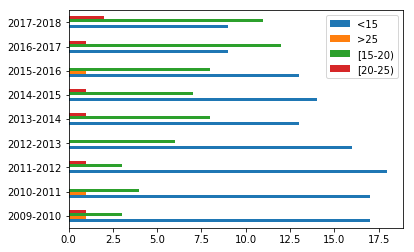

In [12]:
df_private_count.T.plot.barh()

In [13]:
df_public_no_galapagos.max()

Provincia    ZAMORA CHINCHIPE
2009-2010                  28
2010-2011                  26
2011-2012                  26
2012-2013                  25
2013-2014                  26
2014-2015                  27
2015-2016                  28
2016-2017                  27
2017-2018                  26
dtype: object

In [14]:
df_private_no_galapagos.min()

Provincia    AZUAY
2009-2010        0
2010-2011        0
2011-2012        2
2012-2013       10
2013-2014        7
2014-2015        5
2015-2016        5
2016-2017        7
2017-2018        7
dtype: object

### Literacy Indicators and Education Expenditure: Obtaining and Preparing the Data 

In [15]:
educ_exp_raw, = pd.read_html("https://countryeconomy.com/government/expenditure/education/ecuador", header=0, parse_dates=["Date"])

In [16]:
educ_exp_raw['Date'] = pd.to_datetime(educ_exp_raw["Date"]).dt.year
educ_exp_raw.drop(['Education Expenditure (M.€)', 'Education Expenditure P.C', 'Education Expenditure P.C.1'], axis=1, inplace=True)
educ_exp = educ_exp_raw.query("Date > 2009")

educ_exp[educ_exp.columns.unique()[2]] = educ_exp[educ_exp.columns.unique()[2]].apply(lambda st: float(st.replace("%", "")))
educ_exp[educ_exp.columns.unique()[3]] = educ_exp[educ_exp.columns.unique()[3]].apply(lambda st: float(st.replace("%", "")))

educ_exp.set_index('Date', drop=True, inplace=True)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
literacy_raw, = pd.read_html("https://knoema.es/atlas/Ecuador/topics/Educaci%C3%B3n/Alfabetizaci%C3%B3n/Analfabetismo-en-j%C3%B3venes")

In [18]:
literacy_raw.rename(columns={'Fecha':'Date', 
                             'Valor':'Illiterate Youth Population', 
                             literacy_raw.columns.unique()[2]: 'Ptc Change'}, inplace=True)
df_literacy = literacy_raw.query("Date > 2009")

#This table uses european decimal system, multiply by 1000 since all data has 3 decimals 
df_literacy['Illiterate Youth Population'] = df_literacy['Illiterate Youth Population'].apply(lambda x: x*1_000)
df_literacy['Ptc Change'] = df_literacy['Ptc Change'].apply(lambda st: float(st.replace(",", ".").replace("%", "")))

df_literacy.set_index('Date', drop=True, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
lit_and_exp = df_literacy.join(educ_exp, how='outer')

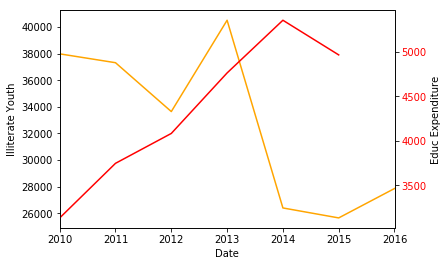

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

eg = lit_and_exp.copy()
eg['Illiterate Youth Population'].plot(ax=ax1, color='orange')
ax1.set_ylabel('Illiterate Youth')

ax2 = ax1.twinx()
eg['Education Expenditure (M.$)'].plot(ax=ax2,color='r')
ax2.set_ylabel('Educ Expenditure', color='black')
for tl in ax2.get_yticklabels():
    tl.set_color('red')

In [22]:
eg = lit_and_exp.copy()
## Reduce the scaling for the graph
eg['Education Expenditure (M.$)'] = eg['Education Expenditure (M.$)']/100

In [23]:
from numpy import nan as Nan

## To match with Ratio data
_2017 = pd.Series([Nan,Nan,Nan,Nan,Nan], index=eg.columns)
eg_ = eg.append(_2017, ignore_index=True)

_2018 = pd.Series([Nan,Nan,Nan,Nan,Nan], index=eg.columns)
eg_to_plot = eg_.append(_2018, ignore_index=True)

###  Obtaining and Preparing GeoData for Plotting

In [24]:
## Shape of Ecuador provinces
fp = 'provincias.shp'
map_df = gpd.read_file(fp)

In [25]:
## Cleaning the data
map_df.drop([4,5,6,7,8], axis=0, inplace=True) ## These are blank polygons
map_df.reset_index(drop = True, inplace=True)

## Order polygon data to match Pronvinces data order
order = [11, 2 , 18, 0, 3, 5, 9, 11, 1, 4, 17, 20, 16, 13, 19, 14, 15, 8, 6, 12, 7]
map_df['order'] = order
map_df = map_df.sort_values('order')
map_df.set_index('order',inplace=True)
map_df.reset_index(drop = True, inplace=True)

In [26]:
## Concate geopandas table with the student-teacher ratio table
table = pd.concat([map_df, df_public_no_galapagos], axis=1)
table_private = pd.concat([map_df, df_private_no_galapagos], axis=1)

### Plotting

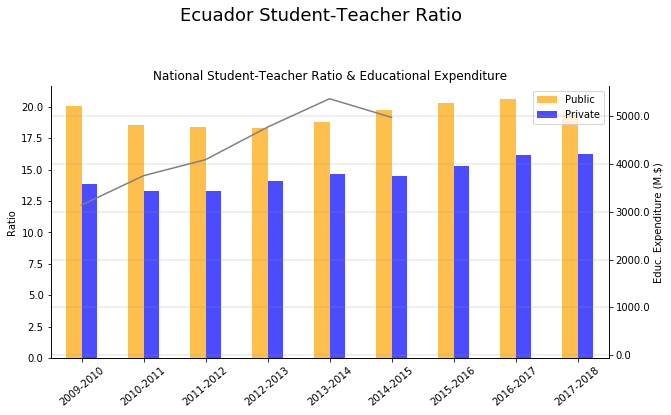

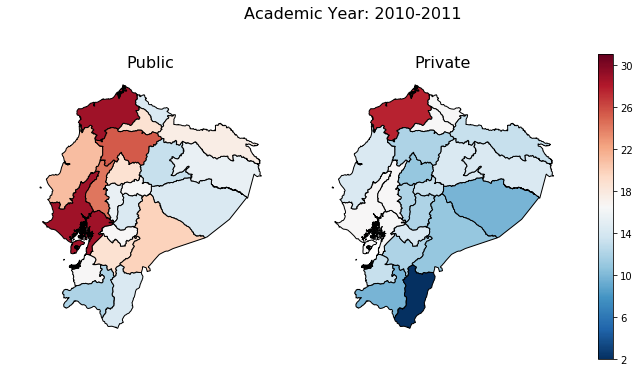

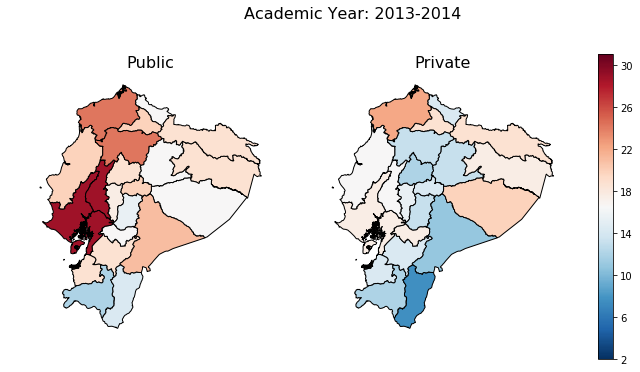

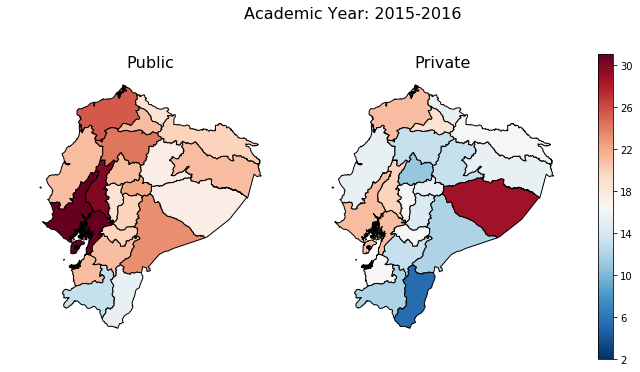

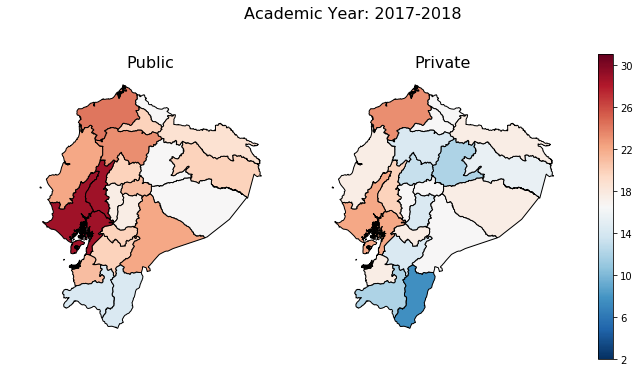

In [27]:
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10,5))

size_sub = 16
vmin = 2
vmax = 28

## Ploting Private and Public National S-T Ratios
to_plot = pd.DataFrame(df_country_ratio_public).rename(columns={0:'Public'}).join(
    pd.DataFrame(df_country_ratio_private).rename(columns={0:'Private'}))

to_plot.plot(ax=ax, kind='bar', color=['orange', 'blue'], alpha = 0.7)
ax.set_ylabel('Ratio', color='black')

## Ploting Education Expenditure
ax2 = ax.twinx()
ax2.plot(ax.get_xticks(),eg_to_plot['Education Expenditure (M.$)'], 2,color='grey')
ax2.set_ylabel('Educ. Expenditure (M.$)', color='black')

#Change horizontal ticks
xticks = df_private_prov.columns.unique()
ax.set_xticklabels(xticks, rotation=40)

#Change vertical right ticks
y2ticks = ax2.get_yticks()*100
ax2.set_yticklabels(y2ticks)

#plt.text(7.5, 15.5, "Private", color='Blue')

#Other settings
plt.grid(linestyle='-', linewidth=1.5, color='#999999', alpha=0.2)
ax.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title("National Student-Teacher Ratio & Educational Expenditure")
plt.suptitle('Ecuador Student-Teacher Ratio', x=.5, y=1.10, size=18)


## MAP PLOTS
years = ['2010-2011', '2013-2014','2015-2016','2017-2018']

for year in years:
    fig, gax = plt.subplots(1, 2, figsize=(12,7),sharey=True)
    fig.suptitle('Academic Year: {}'.format(year), x=.5, y=.9, size=size_sub)


    table.plot(ax=gax[0], edgecolor='black', column=year, legend=False, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    table_private.plot(ax=gax[1], edgecolor='black', column=year, legend=False, cmap='RdBu_r', vmin=vmin, vmax=vmax)

    gax[0].set_title('Public', size=size_sub)
    gax[1].set_title('Private', size=size_sub)

    gax[0].axis('off')
    gax[1].axis('off')


    scalarmappaple = cm.ScalarMappable(cmap='RdBu_r')
    scalarmappaple.set_array(np.arange(vmin,vmax+4))
    cbar = plt.colorbar(scalarmappaple, ax=gax, orientation='vertical',shrink = 0.8)
    cbar.set_ticks(np.arange(vmin,vmax+4, 4))
    cbar.set_ticklabels(np.arange(vmin,vmax+4, 4))
